In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import math
import scipy
from scipy.optimize import minimize

import tqdm as tq
from tqdm.notebook import tqdm

for pkg in [np, pd, matplotlib, scipy, tq]:
    print(pkg.__name__, pkg.__version__)

numpy 1.24.4
pandas 2.1.4
matplotlib 3.6.2
scipy 1.11.4
tqdm 4.66.1


In [2]:
# Where to find/save
path_in = '.'
curpathout = '.'

# Where to get input data
df = pd.read_csv('{}/Activity.csv'.format(path_in))
df['Temperature'] = df['Temperature'].astype(int).astype('category')

# Filter out controls 0.1 (no enzyme) and 0.2 (no solvent)
df = df.query('Concentration != 0.1 and Concentration != 0.2')

  0%|          | 0/72 [00:00<?, ?it/s]

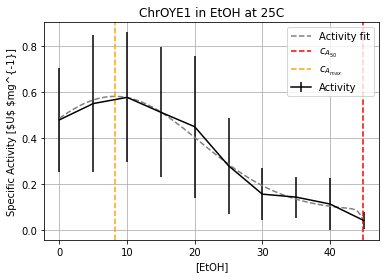

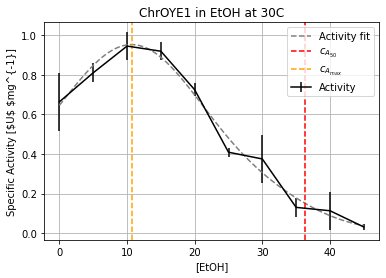

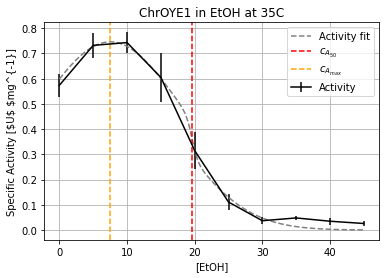

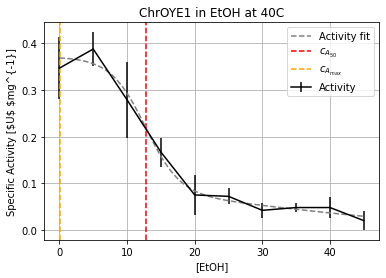

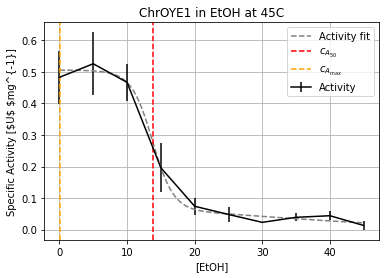

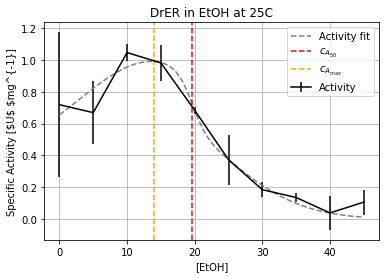

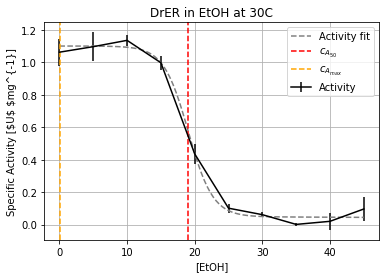

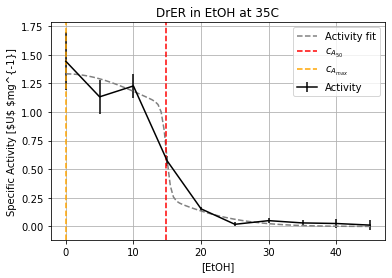

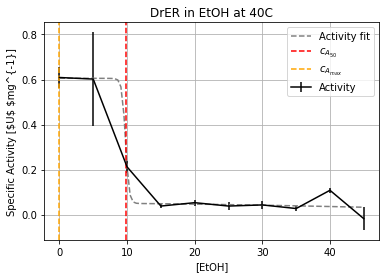

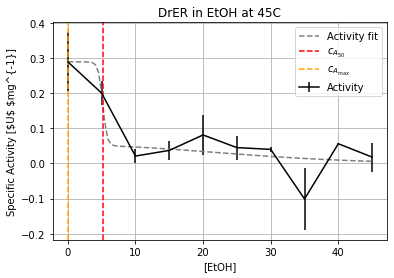

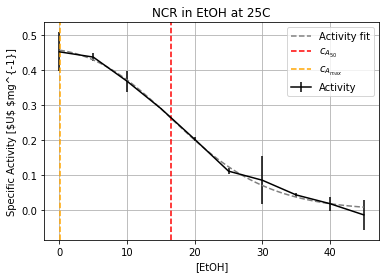

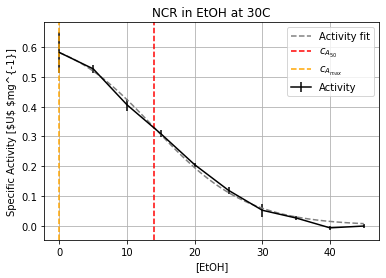

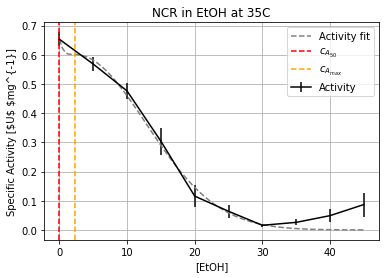

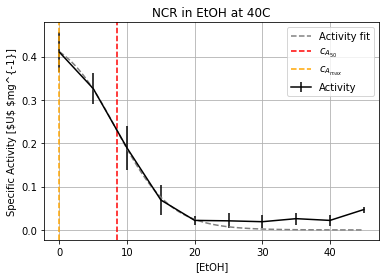

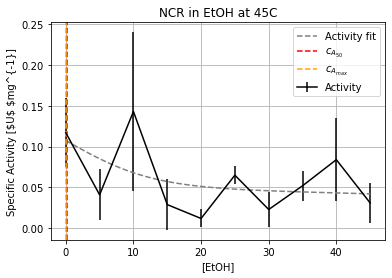

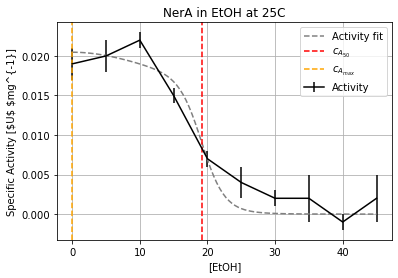

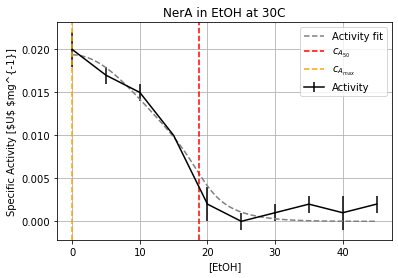

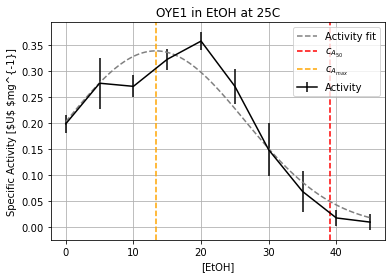

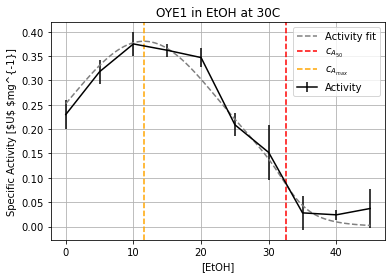

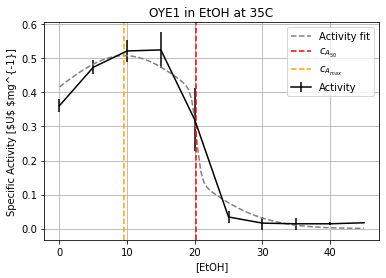

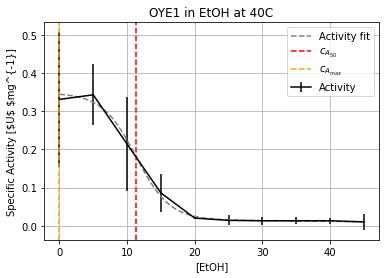

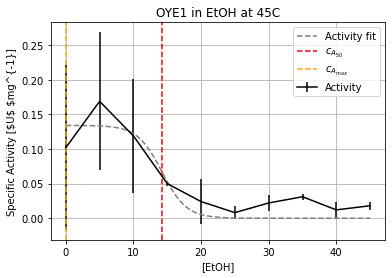

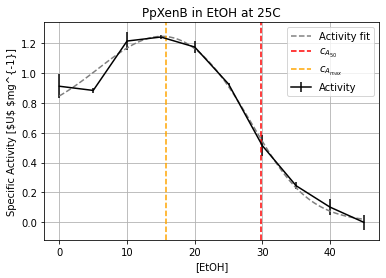

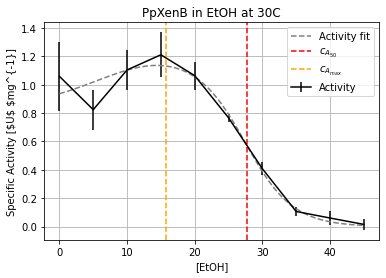

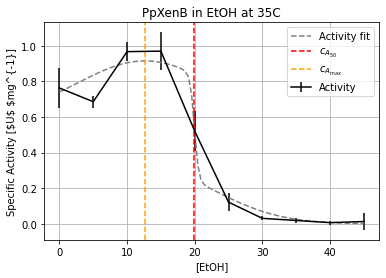

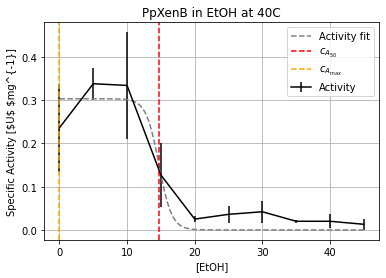

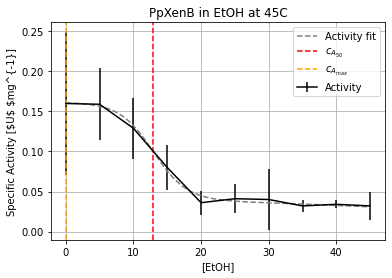

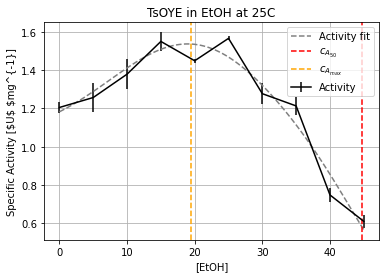

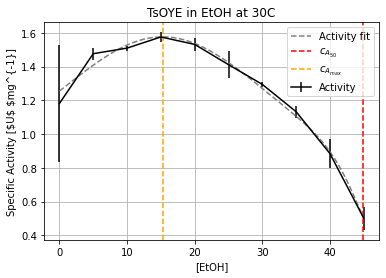

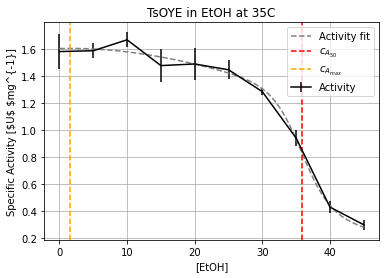

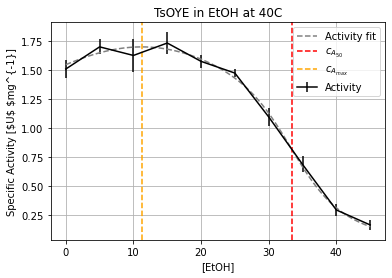

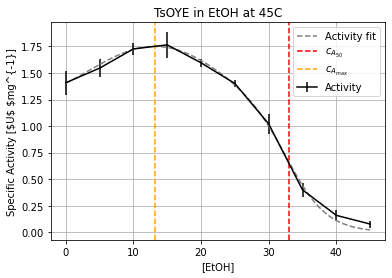

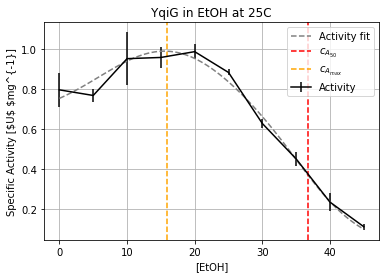

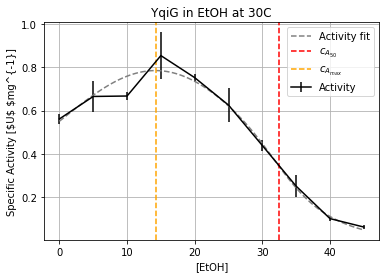

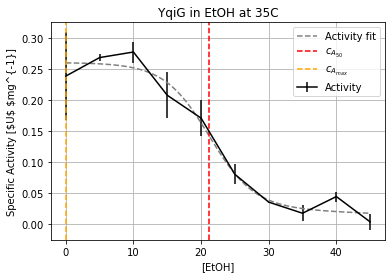

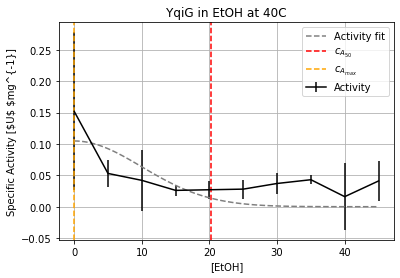

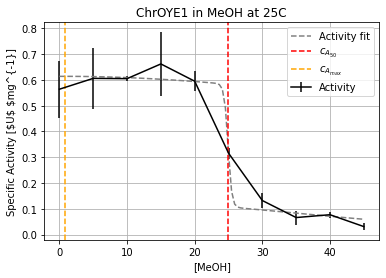

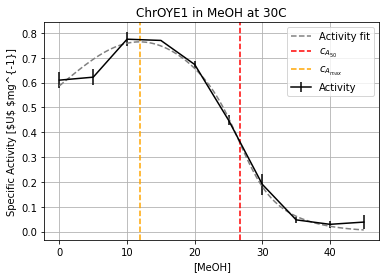

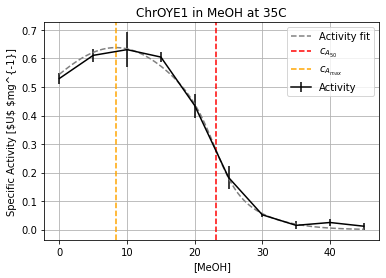

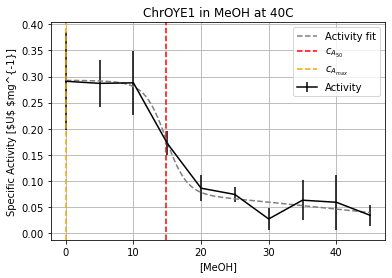

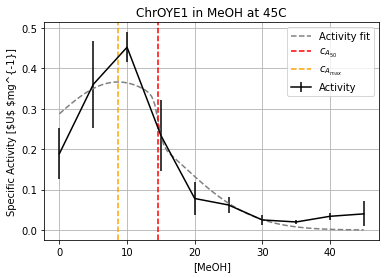

/gpfs/users/home/seemays/Projects/spack-test/sw/milan9/v01/apps/linux-rhel9-zen3/gcc-12.2.0/py-pandas-2.1.4-cjgrdrebepd3wde3fld2oyidi6l4pwb4/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_1163716/3469204735.py:30: RuntimeWarning: overflow encountered in exp
  B * (np.exp(-k * (x - x50))) / (1 + np.exp(-k * (x - x50)))
/tmp/ipykernel_1163716/3469204735.py:30: RuntimeWarning: invalid value encountered in divide
  B * (np.exp(-k * (x - x50))) / (1 + np.exp(-k * (x - x50)))


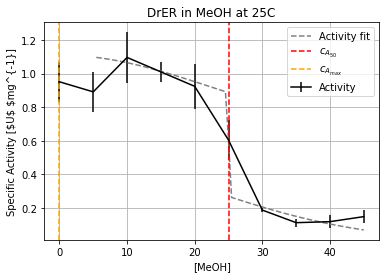

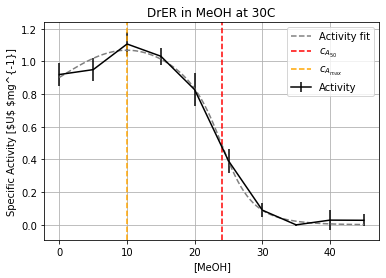

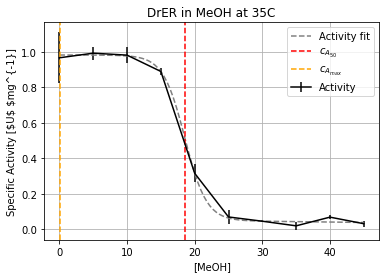

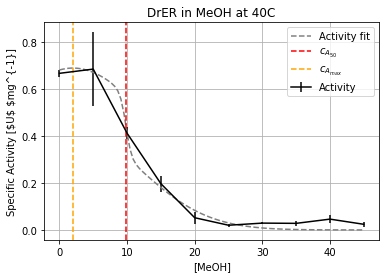

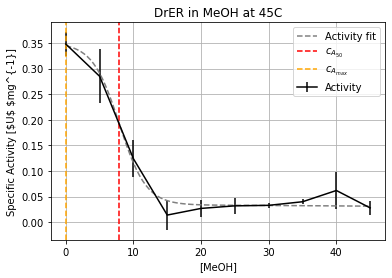

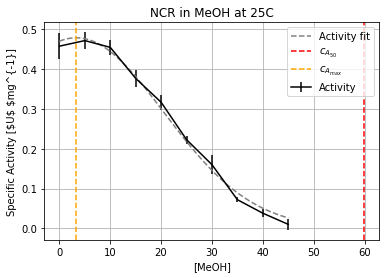

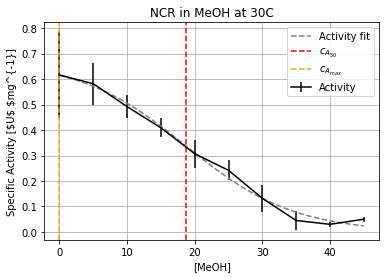

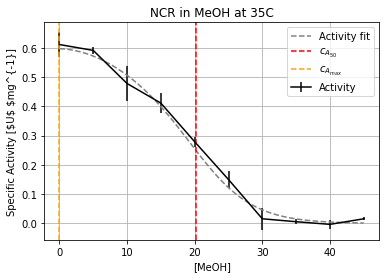

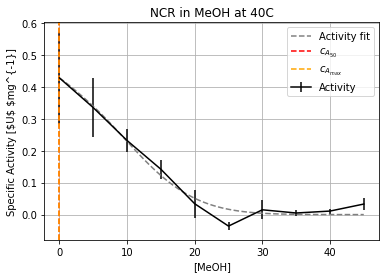

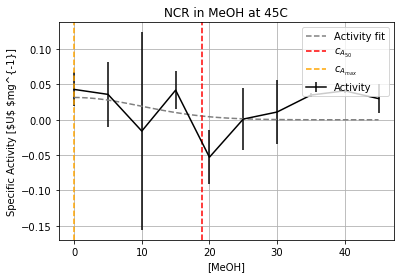

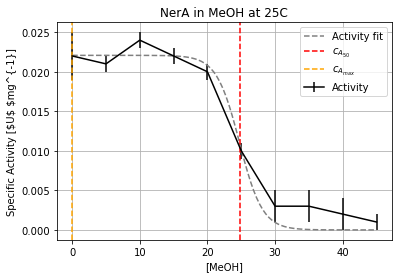

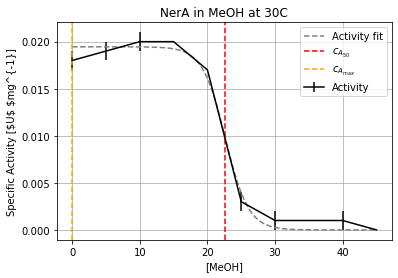

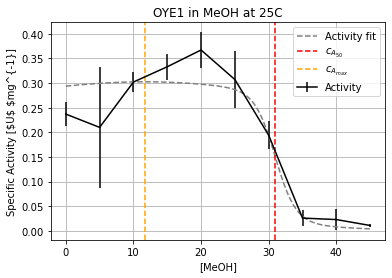

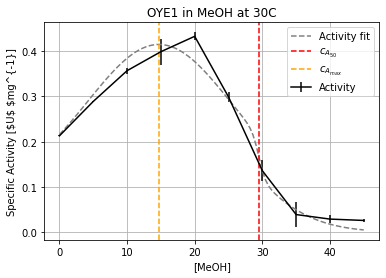

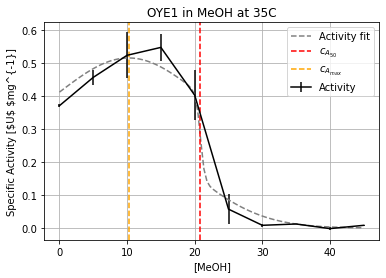

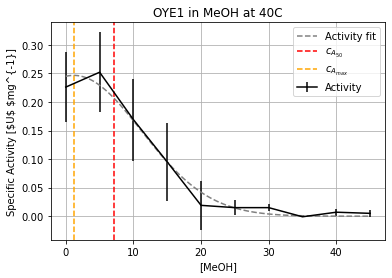

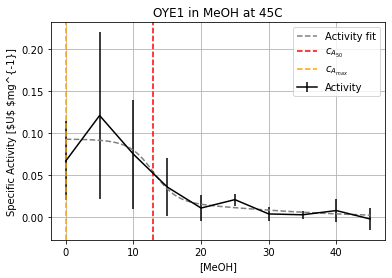

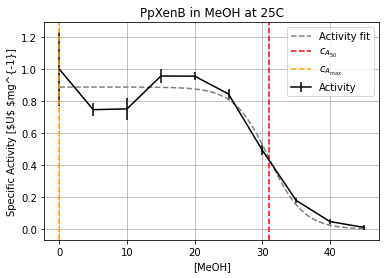

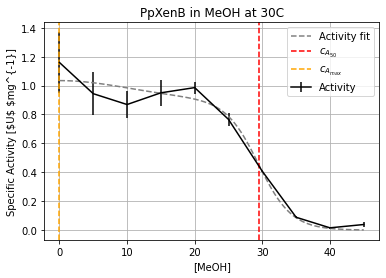

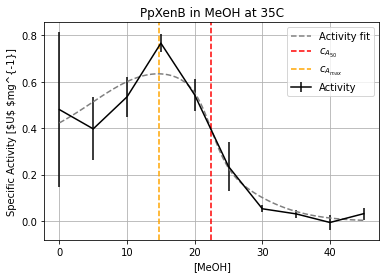

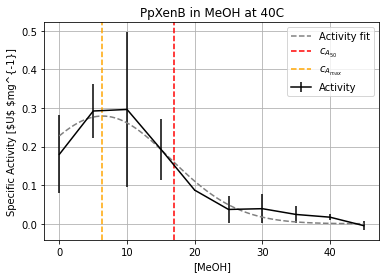

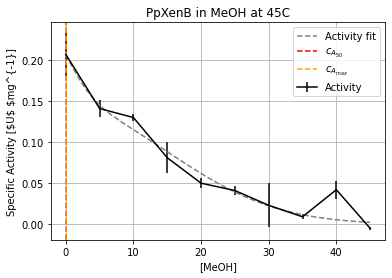

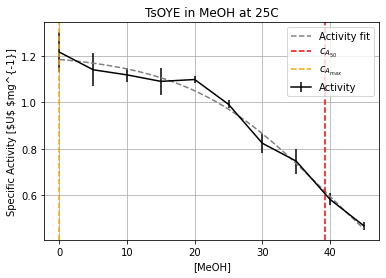

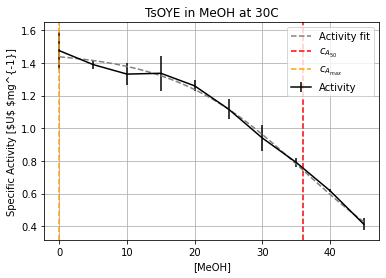

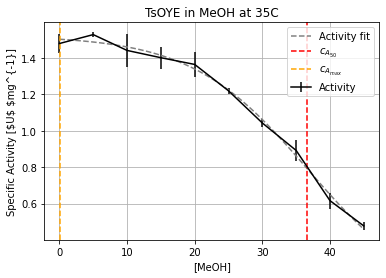

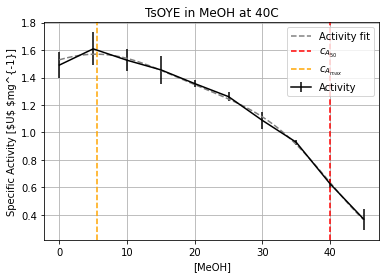

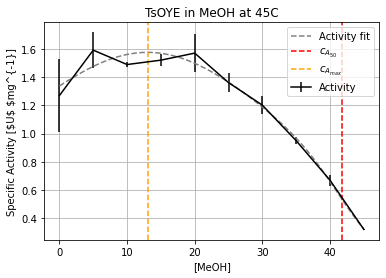

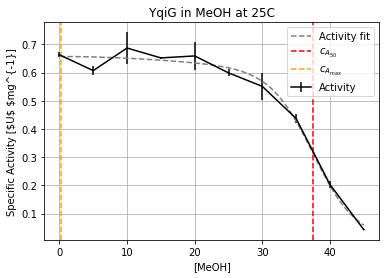

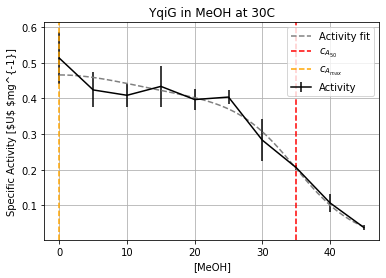

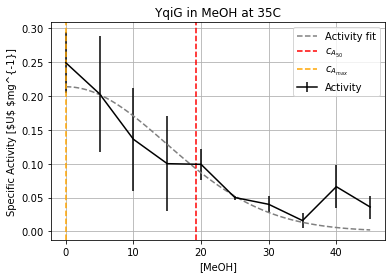

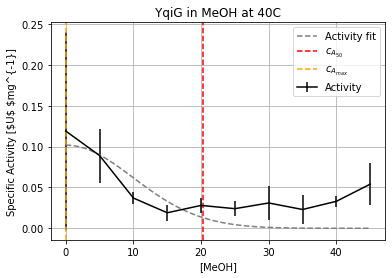

x50          μ          σ          A  \
Solvent Enzyme  Temperature                                               
EtOH    ChrOYE1 25           44.855939   8.182388  12.536256  15.675936   
                30           36.332379  10.697349  10.000000  17.721304   
                35           19.606725   7.528899  10.000000  14.964926   
                40           12.733878   0.078693  31.083538   6.478300   
                45           13.762636   0.090081  28.936322   5.191009   
...                                ...        ...        ...        ...   
MeOH    TsOYE   45           41.759328  13.030477  16.219662  35.199516   
        YqiG    25           37.537652   0.187926  19.933969   2.588346   
                30           34.934706   0.000000  10.000000   1.432724   
                35           19.255435   0.000000  14.878046   7.963587   
                40           20.274041   0.000000  10.000000   2.551795   

                                    B            m  
Solvent Enzyme  Temperature                         
EtOH    ChrOYE1 25           0.083432  6150.871179  
                30           0.247687   524.340979  
                35           0.148856  6376.225936  
                40           0.287737  1015.768164  
                45           0.434199  1711.202027  
...                               ...          ...  
MeOH    TsOYE   45           0.710624   761.761788  
        YqiG    25           0.605048   768.611747  
                30           0.409141   555.724131  
                35           0.000000  1265.181003  
                40           0.000000  1508.677794  

[72 rows x 6 columns]

In [3]:
PARAMETERS = [
    # name, λ,      starting, bounds
    ('x50', 0,      20,       (0, 100)),
    ('μ',   0.01,   10,       (0, 100)),
    ('σ',   0,      10,       (10, None)),
    ('A',   0.001,  1,        (0, None)),
    ('B',   0,      1,        (0, None)),
    ('m',   0,      15.00,    (None, None)),
]

# parameter_names
parameter_names = [n for n, _, _, _ in PARAMETERS]

# regularization coefficients
λ = np.array([l for _, l, _, _ in PARAMETERS])

# starting parameters
θ0 = [v for _, _, v, _ in PARAMETERS]

# parameter boundaries
bounds = [b for _, _, _, b in PARAMETERS]

def model(x, temp, params):
    x50, μ, σ, A, B, m = params
    
    k = m*100 / (8.314 * temp)
    
    return (
        A * np.exp(-0.5 * ((x - μ) / σ) ** 2) / (σ * np.sqrt(2 * np.pi)) +
        B * (np.exp(-k * (x - x50))) / (1 + np.exp(-k * (x - x50)))    
    )

def cost_function(params, x, y, temp):
    least_squares_cost = np.sum( (y - model(x, temp, params)) ** 2)
    regularization_cost = np.sum( (λ * params) ** 2)
    
    return least_squares_cost + regularization_cost


fit_parameters = []
for i, ((solvent, enzyme, temperature), dfg) in enumerate(tqdm(df.groupby(['Solvent', 'Enzyme', 'Temperature'], observed=True))):
    x = dfg['Concentration']
    y = dfg['Activity_mean']
    yerr = dfg['Activity_std']
    temp = temperature + 273
    
    θ = minimize(
        cost_function,
        θ0,                # starting values
        args=(x, y, temp), # data points
        bounds=bounds,     # boundaries for values
    )
    
    fit_parameters.append((solvent, enzyme, temperature, *θ.x))

    plt.figure(i)
    plt.title(f'{enzyme} in {solvent} at {temperature}C')
    plt.xlabel(f'[{solvent}]')
    plt.ylabel('Specific Activity [$U$ $mg^{-1}]')

    # plot data
    #plt.scatter(x, y, color='black', label='Activity')
    plt.errorbar(x, y, yerr, color='black', label='Activity')

    # plot fits
    x50, μ, σ, A, B, m = θ.x
    xrange = np.linspace(np.min(x), np.max(x), 100)
    yhat = model(xrange, temp, θ.x)
    
    plt.plot(xrange, yhat, ls='--', color='gray', label='Activity fit')
    plt.axvline(x=x50, ls='--', color='red', label='$c_{A_{50}}$')
    plt.axvline(x=μ, ls='--', color='orange', label='$c_{A_{max}}$')
    plt.legend(loc='upper right')
    plt.grid()
    plt.show()
    plt.close()
    
df_fits = pd.DataFrame.from_records(fit_parameters, columns=('Solvent', 'Enzyme', 'Temperature', *parameter_names))
df_fits.set_index(['Solvent', 'Enzyme', 'Temperature'], inplace=True)

# Convert scaled values to back to actual values and modify scaling variable accordingly
df_fits['m'] = df_fits['m']*100

df_fits.to_csv(f'{curpathout}/Act_params.csv', index=True)

df_fits